In [1]:
import math
import random
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1),label='w') for _ in range(nin)]
    self.b = Value(random.uniform(-1,1),label='b')
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


<h4>Multi Layer Perceptron</h4?>
<ul>
<li>2 Inputs</li>
<li>1 Layer of 2 neurons</li>
<li>1 output</li>
</ul> 

In [2]:
x = [2.0, 3.0]
n = MLP(2, [2, 1])
myMLP=n(x)
myMLP

Value(data=0.7926661626959604)

In [3]:
xs = [
  [2.0, 3.0],
  [4.0, -1.0],

]
ys = [1.0, -1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7926661626959604), Value(data=0.7864441320802201)]

In [4]:
# loss function
def loss():
    ypred = [n(x) for x in xs]

    total_loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    return total_loss


print(loss())

Value(data=3.2343699571350686)


In [5]:
loss()

Value(data=3.2343699571350686)

In [6]:
a=loss()
a

Value(data=3.2343699571350686)

In [7]:

for k in range(20):
  
  # forward pass
  # ypred = [n(x) for x in xs]
  # loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))


  myloss = loss()

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  myloss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, myloss.data)
  

0 3.2343699571350686
1 2.7191984409803873
2 2.0505389353352697
3 1.8884543058145606
4 1.7856946686379325
5 1.4429871667749985
6 0.6403327991055066
7 0.2368344931634658
8 0.14606980844846867
9 0.10712851264963097
10 0.08526549418795143
11 0.07121629069950124
12 0.061397525689577084
13 0.05412976083367575
14 0.04852061386640124
15 0.0440517260819587
16 0.04040120757463771
17 0.037358497493666556
18 0.03477998910916746
19 0.032564325662790654


In [8]:
ypred

[Value(data=0.7926661626959604), Value(data=0.7864441320802201)]

In [12]:
def opt_implicit():
    for k in range(20):
        
        # forward pass
        ypred = [n(x) for x in xs]
        loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

        # backward pass
        for p in n.parameters():
            p.grad = 0.0
        loss.backward()
        
        # update
        for p in n.parameters():
            p.data += -0.1 * p.grad
        
        print(k, loss.data)

opt_implicit()
ypred

0 0.01465530190347714
1 0.014300605689854248
2 0.013963628586396284
3 0.013643029325800622
4 0.013337601439269594
5 0.013046256536590826
6 0.012768010031826711
7 0.012501968905508946
8 0.012247321170811416
9 0.012003326771970163
10 0.011769309691770884
11 0.011544651083913251
12 0.011328783277538366
13 0.011121184526746453
14 0.010921374398757722
15 0.010728909711425838
16 0.010543380944848763
17 0.010364409063416583
18 0.010191642694254637
19 0.010024755616031271


[Value(data=0.7926661626959604), Value(data=0.7864441320802201)]

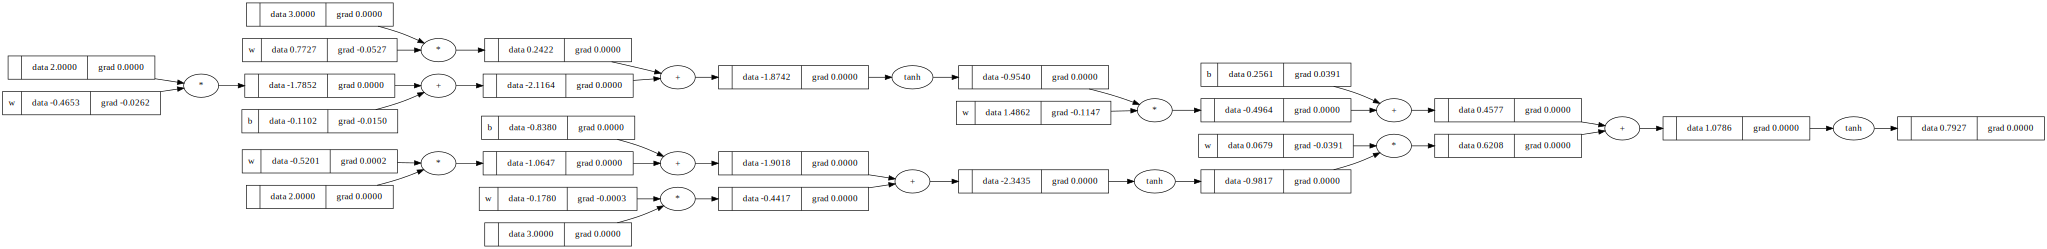

In [9]:
draw_dot(myMLP)